<a href="https://colab.research.google.com/github/acsontfd/NewsScrapers/blob/main/assessment_CGT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install google-colab-selenium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.9/492.9 kB 16.4 MB/s eta 0:00:00


In [2]:
%pip install google-colab-selenium[undetected]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.4/65.4 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for undetected-chromedriver: filename=undetected_chromedriver-3.5.5-py3-none-any.whl size=47048 sha256=1838aae7e868ae6e910c58e4c24eb10ba48e4be5a1ad75b82ce698928aa910e6
  Stored in directory: /root/.cache/pip/wheels/5c/b9/03/4b6e38f019d6170e8c25df2e1e362d7bdf9ff4012df2dc85c0
Successfully built undetected-chromedriver


In [3]:
%pip install selenium webdriver-manager

In [65]:
import time
import requests
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.action_chains import ActionChains
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
import google_colab_selenium as gs
from datetime import datetime, timedelta
import re
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer



driver = gs.Chrome()

<IPython.core.display.Javascript object>

In [31]:
#Convert relative time (e.g. 4 mins ago)to actual date

def get_published_date(relative_time):

    now = datetime.now()

    parts = relative_time.split()
    if len(parts) < 2:
        return now.strftime("%Y-%m-%d %H:%M")  # Return current time if format is unknown

    num, unit = int(parts[0]), parts[1]

    # Convert different time formats
    if "minute" in unit:
        return (now - timedelta(minutes=num)).strftime("%Y-%m-%d %H:%M")
    elif "hour" in unit:
        return (now - timedelta(hours=num)).strftime("%Y-%m-%d %H:%M")
    elif "day" in unit:
        return (now - timedelta(days=num)).strftime("%Y-%m-%d")
    elif "week" in unit:
        return (now - timedelta(weeks=num)).strftime("%Y-%m-%d")

    return now.strftime("%Y-%m-%d")  # Default case

In [32]:
# Regex to check if the extracted text follows a valid date format
def is_valid_date(date_text):
    date_pattern = r"^\d{1,2} [A-Za-z]+( \d{4})?$"  # Matches "11 Feb", "23 February", or "17 December 2024"
    return bool(re.match(date_pattern, date_text))

News Article Scraping


In [33]:
def bbc_articles():
    BASE_URL = 'https://www.bbc.com/news'
    response = requests.get(BASE_URL)

    if response.status_code != 200:
        print(f"Failed to retrieve BBC news. Status code: {response.status_code}")
        return []

    print("The response code is:", response.status_code)

    soup = BeautifulSoup(response.content, 'html.parser')

    # Extract tab links
    tabs = soup.select('nav a')  # Select all navigation links
    tab_links = {tab.text.strip(): f"https://www.bbc.com{tab['href']}" for tab in tabs if tab.get('href') and '/news' in tab['href']}

    articles_data = []

    # Visit each tab and scrape articles
    for category, url in tab_links.items():
        print(f"Scraping category: {category} - {url}")
        response = requests.get(url)
        time.sleep(2)  # Prevent being blocked

        if response.status_code != 200:
            print(f"Failed to retrieve {category} news.")
            continue

        tab_soup = BeautifulSoup(response.content, 'html.parser')
        headlines = tab_soup.find_all("h2", {"data-testid": "card-headline"})
        descriptions = tab_soup.find_all("p", {"data-testid": "card-description"})
        published_dates = tab_soup.find_all("span", {"data-testid": "card-metadata-lastupdated"})

        for i in range(len(headlines)):
            title = headlines[i].text.strip()
            description = descriptions[i].text.strip() if i < len(descriptions) else "No description"
            relative_time = published_dates[i].text.strip() if i < len(published_dates) else "No date"

            articles_data.append({
                "published_date": relative_time,  # Needs date parsing function
                "headline": title,
                "publisher": "BBC",
                "article_content": description,
                "category": category  # Assign the category dynamically
            })

    print(f"Total BBC articles scraped: {len(articles_data)}")
    return articles_data

# Run function
bbc_news = bbc_articles()

The response code is: 200
Scraping category: News - https://www.bbc.com/news
Scraping category: Israel-Gaza War - https://www.bbc.com/news/topics/c2vdnvdg6xxt
Scraping category: War in Ukraine - https://www.bbc.com/news/war-in-ukraine
Scraping category: US & Canada - https://www.bbc.com/news/us-canada
Scraping category: UK - https://www.bbc.com/news/uk
Scraping category: Africa - https://www.bbc.com/news/world/africa
Scraping category: Asia - https://www.bbc.com/news/world/asia
Scraping category: Australia - https://www.bbc.com/news/world/australia
Scraping category: Europe - https://www.bbc.com/news/world/europe
Scraping category: Latin America - https://www.bbc.com/news/world/latin_america
Scraping category: Middle East - https://www.bbc.com/news/world/middle_east
Scraping category: In Pictures - https://www.bbc.com/news/in_pictures
Scraping category: BBC InDepth - https://www.bbc.com/news/bbcindepth
Scraping category: BBC Verify - https://www.bbc.com/news/bbcverify
Total BBC article

In [34]:
df_bbc = pd.DataFrame(bbc_news)
df_bbc.to_csv('bbc_news.csv', index=False)

In [8]:
def bbc_sports_articles():
    URL = 'https://www.bbc.com/sport'
    response = requests.get(URL)

    if response.status_code == 200:
        print("The response code is:", response.status_code)

        soup = BeautifulSoup(response.content, 'html.parser')

        articles_data = []
        headlines = soup.find_all("p", class_="ssrcss-1b1mki6-PromoHeadline")  # Extract headlines
        descriptions = soup.find_all("p", {"data-testid": "card-description"})
        published_dates = soup.find_all("span", class_="ssrcss-1f39n02-VisuallyHidden")  # Extract actual date

        for i in range(len(headlines)):
            title = headlines[i].text.strip()
            description = descriptions[i].text.strip() if i < len(descriptions) else "No description"
            extracted_date = published_dates[i].text.strip() if i < len(published_dates) else "No date"

            # Process extracted date
            if "ago" in extracted_date:
                published_date = get_published_date(extracted_date)  # Convert relative time
            elif is_valid_date(extracted_date):
                try:
                    # Convert absolute date to YYYY-MM-DD if year is present
                    if len(extracted_date.split()) == 3:
                        published_date = datetime.strptime(extracted_date, "%d %B %Y").strftime("%Y-%m-%d")
                    else:
                        # Keep as-is for formats like "23 February"
                        published_date = extracted_date
                except ValueError:
                    published_date = extracted_date  # If conversion fails, store as-is
            else:
                print(f"Skipping invalid date: {extracted_date}")
                continue  # Skip if it's not a valid date

            articles_data.append({
                "published_date": published_date,
                "headline": title,
                "publisher": "BBC",
                "article_content": description,
                "category": "Sports"
            })

        print(f"BBC Sports articles scraped: {len(articles_data)}")
        return articles_data
    else:
        print(f"Failed to retrieve BBC Sports news. Status code: {response.status_code}")
        return []

# Run function
bbc_sports_news = bbc_sports_articles()

The response code is: 200
Skipping invalid date: BBC Homepage
Skipping invalid date: More menu
Skipping invalid date: More menu
Skipping invalid date: Close menu
Skipping invalid date: BBC Sport
Skipping invalid date: Watch: YouTuber MrBeast crashes Formula E car. Video, 00:00:30
Skipping invalid date: Uncle Harry is 'the best supporter ever' - Lampard. Video, 00:02:01
Skipping invalid date: Mourinho falls asleep during reporter's long question. Video, 00:00:34
Skipping invalid date: Chelsea must finish in top four - Colwill. Video, 00:04:03
Skipping invalid date: 'Arriving in red will be cool' - Hamilton's Melbourne excitement. Video, 00:01:12
Skipping invalid date: Russell won't 'bow down' to Verstappen. Video, 00:02:35
Skipping invalid date: Ferguson 'not carried away after brilliant result' Video, 00:00:58
Skipping invalid date: 'Liverpool must improve in PSG second leg' Video, 00:02:17
Skipping invalid date: 'How on earth do you leave him out?' - the Kane debate. Video, 00:01:10
S

In [9]:
def bbc_business_articles():
    URL = 'https://www.bbc.com/news/business'
    response = requests.get(URL)

    if response.status_code == 200:
        print("The response code is:", response.status_code)

        soup = BeautifulSoup(response.content, 'html.parser')

        articles_data = []
        headlines = soup.find_all("h2", {"data-testid": "card-headline"})
        descriptions = soup.find_all("p", {"data-testid": "card-description"})
        published_dates = soup.find_all("span", {"data-testid": "card-metadata-lastupdated"})

        for i in range(len(headlines)):
            title = headlines[i].text.strip()
            description = descriptions[i].text.strip() if i < len(descriptions) else "No description"
            relative_time = published_dates[i].text.strip() if i < len(published_dates) else "No date"

            # Ensure relative_time is defined before using it
            if "ago" in relative_time:
                published_date = get_published_date(relative_time)
            else:
                published_date = relative_time  # Keep the original date if not relative

            articles_data.append({
                "published_date": published_date,
                "headline": title,
                "publisher": "BBC",
                "article_content": description,
                "category": "Business"
            })

        print(f"BBC Business articles scraped: {len(articles_data)}")
        return articles_data
    else:
        print(f"Failed to retrieve BBC Business news. Status code: {response.status_code}")
        return []

# Run function
bbc_business_news = bbc_business_articles()

The response code is: 200
BBC Business articles scraped: 42


In [10]:
def scrape_thestar_nation():
    URL = "https://www.thestar.com.my/news/nation"

    # Set up Selenium WebDriver
    options = webdriver.ChromeOptions()
    options.add_argument("--headless")  # Run in headless mode (optional)
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")

    # Use webdriver_manager to install ChromeDriver automatically
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
    driver.get(URL)
    wait = WebDriverWait(driver, 10)

    max_clicks = 10
    click_count = 0

    while click_count < max_clicks:
        try:
            # Scroll down to make the "Load More" button visible
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            time.sleep(1.5)

            # Find and click the "Load More" button
            load_more_button = wait.until(EC.element_to_be_clickable((By.ID, "loadMorestories")))
            driver.execute_script("arguments[0].click();", load_more_button)

            click_count += 1
            print(f"Clicked Load More {click_count} time(s)...")

            # Wait for new articles to load
            time.sleep(2)

        except Exception:
            print("No more articles to load or Load More button not found.")
            break  # Exit loop when no more articles

    # Parse page source with BeautifulSoup
    soup = BeautifulSoup(driver.page_source, "html.parser")

    articles_data = []
    news_items = soup.find_all("div", class_="row list-listing")  # Each news item

    for item in news_items:
        # Extract headline
        headline_tag = item.find("h2", class_="f18")
        headline = headline_tag.a.text.strip() if headline_tag and headline_tag.a else "No headline"

        # Extract description
        description_tag = item.find("p", style="overflow-wrap: break-word;")
        description = description_tag.text.strip() if description_tag else "No description"

        # Extract timestamp
        timestamp_tag = item.find("label", class_="timestamp")
        published_date = timestamp_tag.text.strip() if timestamp_tag else "No date"

        # Convert relative timestamps like "7m ago"
        if "ago" in published_date:
            published_date = datetime.now().strftime("%Y-%m-%d")

        articles_data.append({
            "published_date": published_date,
            "headline": headline,
            "publisher": "The Star",
            "article_content": description,
            "category": "Nation",
        })

    print(f"Total articles scraped: {len(articles_data)}")

    # Close the browser
    driver.quit()

    return articles_data

# Run scraper
thestar_nation_news = scrape_thestar_nation()

Clicked Load More 1 time(s)...
Clicked Load More 2 time(s)...
Clicked Load More 3 time(s)...
Clicked Load More 4 time(s)...
Clicked Load More 5 time(s)...
Clicked Load More 6 time(s)...
Clicked Load More 7 time(s)...
Clicked Load More 8 time(s)...
Clicked Load More 9 time(s)...
Clicked Load More 10 time(s)...
Total articles scraped: 110


In [46]:
def scrape_thestar_business():
    BASE_URL = "https://www.thestar.com.my/news/latest?pgno={}&tag=Business#Latest"

    # Set up Selenium WebDriver
    options = webdriver.ChromeOptions()
    options.add_argument("--headless")  # Run in headless mode (optional)
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")

    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

    max_pages = 8  # Scrape 8 pages
    articles_data = []

    for page_num in range(1, max_pages + 1):
        current_url = BASE_URL.format(page_num)
        print(f"Scraping page {page_num}: {current_url}")

        driver.get(current_url)
        time.sleep(5)  # Allow page to load

        # Parse page source with BeautifulSoup
        soup = BeautifulSoup(driver.page_source, "html.parser")

        news_items = soup.find_all("li", class_="row")  # Each news item

        for item in news_items:
            # Extract headline
            headline_tag = item.find("h2", class_="f18")
            headline = headline_tag.a.text.strip() if headline_tag and headline_tag.a else "No headline"

            # Extract description
            description_tag = item.find("p", style="overflow-wrap: break-word;")
            description = description_tag.text.strip() if description_tag else "No description"

            # Extract timestamp
            timestamp_tag = item.find("time", class_="timestamp")
            published_date = timestamp_tag.text.strip() if timestamp_tag else "No date"

            # Convert relative timestamps like "7m ago"
            if "ago" in published_date:
                published_date = datetime.now().strftime("%Y-%m-%d")

            articles_data.append({
                "published_date": published_date,
                "headline": headline,
                "publisher": "The Star",
                "article_content": description,
                "category": "Business",
            })

    print(f"Total articles scraped: {len(articles_data)}")

    # Close the browser
    driver.quit()

    return articles_data

# Run scraper
thestar_business_news = scrape_thestar_business()

Scraping page 1: https://www.thestar.com.my/news/latest?pgno=1&tag=Business#Latest
Scraping page 2: https://www.thestar.com.my/news/latest?pgno=2&tag=Business#Latest
Scraping page 3: https://www.thestar.com.my/news/latest?pgno=3&tag=Business#Latest
Scraping page 4: https://www.thestar.com.my/news/latest?pgno=4&tag=Business#Latest
Scraping page 5: https://www.thestar.com.my/news/latest?pgno=5&tag=Business#Latest
Scraping page 6: https://www.thestar.com.my/news/latest?pgno=6&tag=Business#Latest
Scraping page 7: https://www.thestar.com.my/news/latest?pgno=7&tag=Business#Latest
Scraping page 8: https://www.thestar.com.my/news/latest?pgno=8&tag=Business#Latest
Total articles scraped: 160


In [47]:
def scrape_nst_nation():
    BASE_URL = "https://www.nst.com.my/news/nation"
    max_pages = 8  # Total pages to scrape
    articles_data = []

    # Set up Selenium WebDriver
    options = webdriver.ChromeOptions()
    options.add_argument("--headless")  # Run in headless mode
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")

    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

    for page in range(1, max_pages + 1):
        URL = f"{BASE_URL}?page={page}"
        print(f"Scraping: {URL}")
        driver.get(URL)
        time.sleep(5)  # Allow time for JS to load

        soup = BeautifulSoup(driver.page_source, "html.parser")

        # Locate all news articles
        news_items = soup.find_all("div", class_="col")

        if not news_items:
            print("No more articles found. Stopping.")
            break  # Stop if no articles are found

        for item in news_items:
            # Extract headline
            headline_tag = item.find("h6", class_="field-title")
            headline = headline_tag.text.strip() if headline_tag else "No headline"

            # Extract description/snippet
            description_tag = item.find("div", class_="d-block article-teaser")
            description = description_tag.text.strip() if description_tag else "No description"

            # Extract timestamp
            timestamp_tag = item.find("span", class_="created-ago")
            published_date = timestamp_tag.text.strip() if timestamp_tag else "No date"

            # Convert relative timestamps like "7m ago"
            if "ago" in published_date:
                published_date = datetime.now().strftime("%Y-%m-%d")

            articles_data.append({
                "published_date": published_date,
                "headline": headline,
                "publisher": "NST",
                "article_content": description,
                "category": "Nation",
            })

        print(f"Total articles scraped so far: {len(articles_data)}")

    driver.quit()
    return articles_data

# Run scraper
nst_nation_news = scrape_nst_nation()

Scraping: https://www.nst.com.my/news/nation?page=1
Total articles scraped so far: 21
Scraping: https://www.nst.com.my/news/nation?page=2
Total articles scraped so far: 42
Scraping: https://www.nst.com.my/news/nation?page=3
Total articles scraped so far: 63
Scraping: https://www.nst.com.my/news/nation?page=4
Total articles scraped so far: 84
Scraping: https://www.nst.com.my/news/nation?page=5
Total articles scraped so far: 105
Scraping: https://www.nst.com.my/news/nation?page=6
Total articles scraped so far: 126
Scraping: https://www.nst.com.my/news/nation?page=7
Total articles scraped so far: 147
Scraping: https://www.nst.com.my/news/nation?page=8
Total articles scraped so far: 168


In [44]:
def scrape_alj_news():
    BASE_URL = "https://www.aljazeera.com/news/"

    # Set up Selenium WebDriver
    options = webdriver.ChromeOptions()
    options.add_argument("--headless")  # Run in headless mode
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")

    driver = gs.Chrome(options=options)
    driver.get(BASE_URL)
    time.sleep(3)  # Allow page to load

    # Click "Show More" button 10 times
    for i in range(10):
        try:
            show_more_button = driver.find_element(By.CLASS_NAME, "show-more-button")
            driver.execute_script("arguments[0].click();", show_more_button)
            time.sleep(5)  # Wait for content to load
            print(f"Clicked 'Show More' button {i + 1} times")
        except NoSuchElementException:
            print("No 'Show More' button found. Exiting loop.")
            break

    # Parse the page source
    soup = BeautifulSoup(driver.page_source, "html.parser")
    driver.quit()

    # Extract articles
    articles = []
    news_feed = soup.find("section", id="news-feed-container")
    if news_feed:
        news_items = news_feed.find_all("article")
        for item in news_items:
            headline_tag = item.find("h3", class_="gc__title")
            description_tag = item.find("p")
            date_tag = item.find("div", class_="date-simple")

            published_date = date_tag.text.strip() if date_tag else "No date"
            headline = headline_tag.text.strip() if headline_tag else "No title"
            article_content = description_tag.text.strip() if description_tag else "No content"

            articles.append({
                "published_date": published_date,
                "headline": headline,
                "publisher": "Al Jazeera",
                "article_content": article_content,
                "category": "General",
            })

    print(f"Total articles scraped: {len(articles)}")
    return articles

# Run the scraper
alj_news = scrape_alj_news()

<IPython.core.display.Javascript object>

Clicked 'Show More' button 1 times
Clicked 'Show More' button 2 times
Clicked 'Show More' button 3 times
Clicked 'Show More' button 4 times
Clicked 'Show More' button 5 times
Clicked 'Show More' button 6 times
Clicked 'Show More' button 7 times
Clicked 'Show More' button 8 times
Clicked 'Show More' button 9 times
Clicked 'Show More' button 10 times
Total articles scraped: 110


In [16]:
def scrape_aljazeera_sports():
    BASE_URL = "https://www.aljazeera.com/sports/"

    # Set up Selenium WebDriver
    options = webdriver.ChromeOptions()
    options.add_argument("--headless")  # Run in headless mode
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")

    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
    driver.get(BASE_URL)
    time.sleep(3)  # Allow page to load

    # Click "Show More" button 10 times
    for i in range(10):
        try:
            show_more_button = driver.find_element(By.CLASS_NAME, "show-more-button")
            driver.execute_script("arguments[0].click();", show_more_button)
            time.sleep(3)  # Wait for content to load
            print(f"Clicked 'Show More' button {i + 1} times")
        except NoSuchElementException:
            print("No 'Show More' button found. Exiting loop.")
            break

    # Parse the page source
    soup = BeautifulSoup(driver.page_source, "html.parser")
    driver.quit()

    # Extract articles
    articles = []
    news_feed = soup.find("section", id="news-feed-container")
    if news_feed:
        news_items = news_feed.find_all("article")
        for item in news_items:
            headline_tag = item.find("h3", class_="gc__title")
            description_tag = item.find("p")
            date_tag = item.find("div", class_="date-simple")

            published_date = date_tag.text.strip() if date_tag else "No date"
            headline = headline_tag.text.strip() if headline_tag else "No title"
            article_content = description_tag.text.strip() if description_tag else "No content"

            articles.append({
                "published_date": published_date,
                "headline": headline,
                "publisher": "Al Jazeera",
                "article_content": article_content,
                "category": "Sports",
            })

    print(f"Total articles scraped: {len(articles)}")
    return articles

# Run the scraper
sports_news = scrape_aljazeera_sports()

Clicked 'Show More' button 1 times
Clicked 'Show More' button 2 times
Clicked 'Show More' button 3 times
Clicked 'Show More' button 4 times
Clicked 'Show More' button 5 times
Clicked 'Show More' button 6 times
Clicked 'Show More' button 7 times
Clicked 'Show More' button 8 times
Clicked 'Show More' button 9 times
Clicked 'Show More' button 10 times
Total articles scraped: 110


Data Preprocessing

In [96]:
# Function to extract and standardize date format
def clean_date(published_date):
    today = datetime.today()

    # Convert relative dates like "5 days ago", "4 hrs ago", "10 mins ago"
    relative_match = re.search(r"(\d+)\s+(day|hour|hr|minute|min|second|sec)s?\s+ago", published_date, re.IGNORECASE)
    if relative_match:
        value, unit = int(relative_match.group(1)), relative_match.group(2).lower()
        if unit in ["day", "days"]:
            return (today - timedelta(days=value)).strftime("%Y-%m-%d")
        elif unit in ["hour", "hr", "hours", "hrs"]:
            return (today - timedelta(hours=value)).strftime("%Y-%m-%d")
        elif unit in ["minute", "min", "minutes", "mins"]:
            return (today - timedelta(minutes=value)).strftime("%Y-%m-%d")
        elif unit in ["second", "sec", "seconds", "secs"]:
            return (today - timedelta(seconds=value)).strftime("%Y-%m-%d")

    # Match standard date formats like "8 Mar 2025" or "Mar 8, 2025 @ 9:50am"
    standard_match = re.search(r"(\d{1,2} \w{3} \d{4})|(\w{3} \d{1,2}, \d{4})", published_date)
    if standard_match:
        extracted_date = standard_match.group(0)
        try:
            if "," in extracted_date:  # Format like "Mar 8, 2025"
                return datetime.strptime(extracted_date, "%b %d, %Y").strftime("%Y-%m-%d")
            else:  # Format like "8 Mar 2025"
                return datetime.strptime(extracted_date, "%d %b %Y").strftime("%Y-%m-%d")
        except ValueError:
            return "Invalid date"

    # Handle cases like "11 February" or "March 5" (without a year)
    month_day_match = re.search(r"(\d{1,2}) (\w+)", published_date)
    if month_day_match:
        day, month = month_day_match.groups()
        try:
            parsed_date = datetime.strptime(f"{day} {month} {today.year}", "%d %B %Y")
            if parsed_date > today:  # If date is in the future, assume last year
                parsed_date = parsed_date.replace(year=today.year - 1)
            return parsed_date.strftime("%Y-%m-%d")
        except ValueError:
            return "Invalid date"

    return published_date  # Return unchanged if no match found

In [104]:
# Function to remove rows with 'No date' or 'Invalid date'
def null_date_remover(df):
    df = df[~df["published_date"].astype(str).str.lower().isin(["no date", "invalid date"])]
    df = df.reset_index(drop=True)
    return df

In [106]:
# Combine all scraped data into a DataFrame
df_date = pd.DataFrame(
    bbc_news
    + bbc_sports_news
    + bbc_business_news
    + thestar_nation_news
    + thestar_business_news
    + nst_nation_news
    + sports_news
    + alj_news
)

# Apply function to clean 'published_date' column
df_date["published_date"] = df_date["published_date"].apply(clean_date)

# Remove invalid and missing dates
df_date = null_date_remover(df_date)

# Display cleaned DataFrame
print(df_date.head())

# Save to CSV
df_date.to_csv("news_date.csv", index=False)

  published_date                                           headline publisher  \
0     2025-03-09  Syrian security forces accused of killing hund...       BBC   
1     2025-03-09  How Trump's threats have brought Canada's Libe...       BBC   
2     2025-03-09  Migrant deported in chains: 'No-one will go to...       BBC   
3     2025-03-09  Who is in the running to replace Trudeau as Li...       BBC   
4     2025-03-09  Not so demure any more: The rise of 'free the ...       BBC   

                                     article_content category  
0  More than 700 civilians of the Alawite religio...     News  
1  Justin Trudeau's party was headed for near-cer...     News  
2  Indian deportee tells BBC about his risky jour...     News  
3  The winner will be announced on Sunday - a for...     News  
4  Stars like Charli XCX have made see-through ou...     News  


EDA

---


Summary Statistics


In [107]:
df_date.describe()

,published_date,headline,publisher,article_content,category
count,1175,1175,1175,1175,1175
unique,60,966,4,840,18
top,2025-03-08,Migrant deported in chains: 'No-one will go to...,BBC,No description,Nation
freq,263,7,517,140,278


In [108]:
df_date.isnull().sum()


,0
published_date,0
headline,0
publisher,0
article_content,0
category,0


In [109]:
df_date.nunique()

,0
published_date,60
headline,966
publisher,4
article_content,840
category,18


Data Distribution Analysis

publisher
BBC           517
The Star      270
Al Jazeera    220
NST           168
Name: count, dtype: int64
category
Nation             278
Business           202
Sports             131
General            110
News                42
Africa              40
BBC Verify          40
UK                  37
Israel-Gaza War     34
US & Canada         34
Europe              33
Middle East         32
War in Ukraine      29
Asia                28
Australia           28
In Pictures         28
Latin America       28
BBC InDepth         21
Name: count, dtype: int64


<ipython-input-110-e6e262550cc8>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df_date["publisher"], order=df_date["publisher"].value_counts().index, palette="viridis")


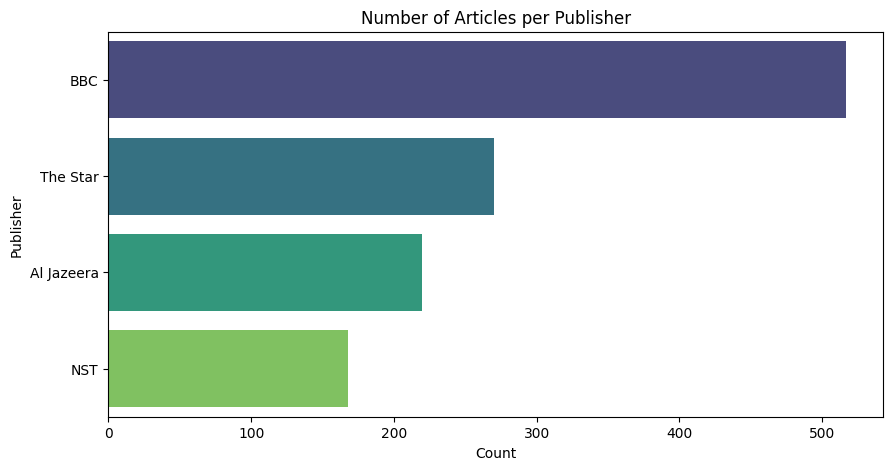

In [110]:
# Count articles by source
print(df_date["publisher"].value_counts())

# Count articles by category
print(df_date["category"].value_counts())

plt.figure(figsize=(10, 5))
sns.countplot(y=df_date["publisher"], order=df_date["publisher"].value_counts().index, palette="viridis")
plt.title("Number of Articles per Publisher")
plt.xlabel("Count")
plt.ylabel("Publisher")
plt.show()

Earliest article date: 2023-01-17 00:00:00
Latest article date: 2025-03-09 00:00:00


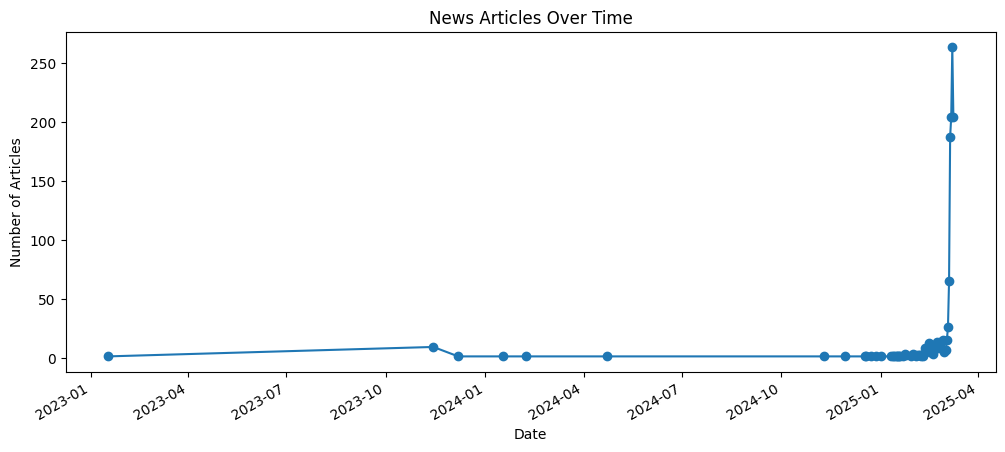

In [111]:
# Convert published_date to datetime
df_date["published_date"] = pd.to_datetime(df_date["published_date"], errors="coerce")

# Check the earliest and latest dates
print("Earliest article date:", df_date["published_date"].min())
print("Latest article date:", df_date["published_date"].max())

# Count articles per day
df_date["published_date"].value_counts().sort_index().plot(
    figsize=(12, 5), kind="line", marker="o", title="News Articles Over Time"
)
plt.xlabel("Date")
plt.ylabel("Number of Articles")
plt.show()

Feature Extraction

In [130]:
category_mapping = {
    "Nation": "Nation",
    "Business": "Business",
    "Sports": "Sports",
    "General": "General",
    "News": "General",
    "BBC Verify": "General",
    "BBC InDepth": "General",
    "In Pictures": "General",
    "Israel-Gaza War": "World News",
    "War in Ukraine": "World News",
    "US & Canada": "World News",
    "UK": "World News",
    "Europe": "World News",
    "Middle East": "World News",
    "Africa": "World News",
    "Asia": "World News",
    "Australia": "World News",
    "Latin America": "World News"
}

# Apply category mapping to df_date
df_date["category"] = df_date["category"].replace(category_mapping)

# Save the updated DataFrame to CSV
df_date.to_csv("news_date.csv", index=False)

# Count new category distribution
print(df["category"].value_counts())

category
World News    323
Nation        278
Business      202
General       131
Sports        118
Name: count, dtype: int64


<ipython-input-131-cc92cf4ab411>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df_date["category"], order=df_date["category"].value_counts().index, palette="Set2")


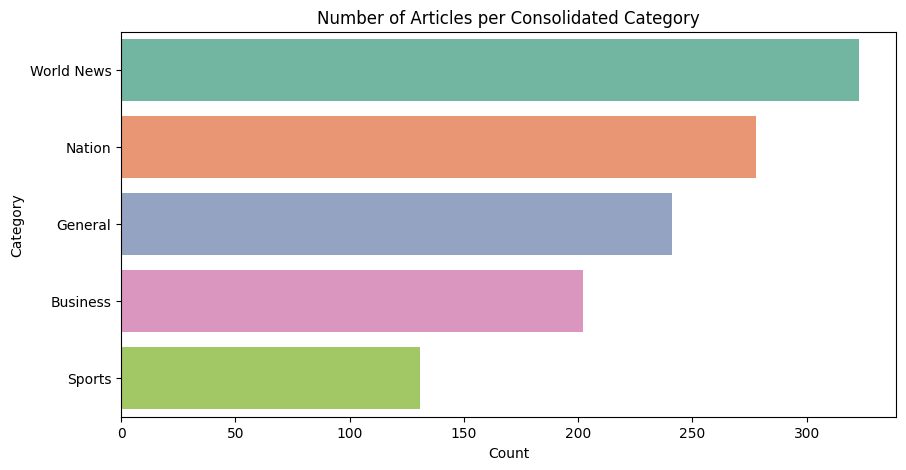

In [131]:
plt.figure(figsize=(10, 5))
sns.countplot(y=df_date["category"], order=df_date["category"].value_counts().index, palette="Set2")
plt.title("Number of Articles per Consolidated Category")
plt.xlabel("Count")
plt.ylabel("Category")
plt.show()

Convert the preprocessed text into numerical vectors

In [132]:
# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

# Fit and transform the text data
tfidf_matrix = tfidf_vectorizer.fit_transform(df_date["article_content"])

# Convert to DataFrame for analysis
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

print(tfidf_df.head())  # View sample vectorized features

   000  000m   10  100mil  105  106  107   11  117  118  ...  zealand  \
0  0.0   0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...      0.0   
1  0.0   0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...      0.0   
2  0.0   0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...      0.0   
3  0.0   0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...      0.0   
4  0.0   0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...      0.0   

   zelensky  zelenskyy  zensen  zero  zig  zoe  zone   zs  zte  
0       0.0        0.0     0.0   0.0  0.0  0.0   0.0  0.0  0.0  
1       0.0        0.0     0.0   0.0  0.0  0.0   0.0  0.0  0.0  
2       0.0        0.0     0.0   0.0  0.0  0.0   0.0  0.0  0.0  
3       0.0        0.0     0.0   0.0  0.0  0.0   0.0  0.0  0.0  
4       0.0        0.0     0.0   0.0  0.0  0.0   0.0  0.0  0.0  

[5 rows x 4533 columns]


In [133]:
from sklearn.model_selection import train_test_split

# Assume df['category'] is the target variable and df['article_content'] contains the news text
X = df_date['article_content']
y = df_date['category']

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [134]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Define a pipeline with TF-IDF and Logistic Regression
model_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=5000, stop_words="english")),
    ("classifier", LogisticRegression(multi_class="ovr", solver="liblinear"))
])

# Train the model
model_pipeline.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=5000, stop_words='english')),
                ('classifier',
                 LogisticRegression(multi_class='ovr', solver='liblinear'))])

In [135]:
from sklearn.metrics import classification_report

# Make predictions
y_pred = model_pipeline.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Business       0.97      0.75      0.85        40
     General       0.36      0.19      0.25        48
      Nation       0.77      0.89      0.83        56
      Sports       0.89      0.62      0.73        26
  World News       0.53      0.78      0.63        65

    accuracy                           0.66       235
   macro avg       0.70      0.65      0.66       235
weighted avg       0.67      0.66      0.65       235



Word2Vec

In [137]:
import pandas as pd
import numpy as np
import re
import nltk
import gensim
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Download NLTK resources if not done
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("stopwords")

# Load your dataset
df_date = pd.read_csv("news_date.csv")  # Ensure your dataset has "category" and "article_content"

# Preprocessing function
stop_words = set(stopwords.words("english"))

def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    words = word_tokenize(text)  # Tokenize
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    return words

# Apply preprocessing
df_date["tokens"] = df_date["article_content"].astype(str).apply(preprocess_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [138]:
# Train Word2Vec on tokenized data
w2v_model = Word2Vec(sentences=df_date["tokens"], vector_size=100, window=5, min_count=2, workers=4)

# Save the trained model
w2v_model.save("word2vec.model")

In [139]:
# Function to get vector representation of a document
def get_w2v_vector(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

# Convert all articles into vector representations
df_date["vector"] = df_date["tokens"].apply(lambda x: get_w2v_vector(x, w2v_model))
X = np.vstack(df_date["vector"].values)
y = df_date["category"]

In [140]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Train a classifier (Random Forest)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

# Evaluate performance
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Business       0.62      0.53      0.57        40
     General       0.31      0.25      0.28        48
      Nation       0.71      0.70      0.70        56
      Sports       0.80      0.31      0.44        26
  World News       0.52      0.77      0.62        65

    accuracy                           0.55       235
   macro avg       0.59      0.51      0.52       235
weighted avg       0.57      0.55      0.54       235

